In [1]:
import numpy as np
import pandas as pd
from scipy.stats import linregress
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import datetime
import cartopy
from matplotlib.colors import LinearSegmentedColormap
import numpy.ma as ma
from netCDF4 import Dataset
from matplotlib import gridspec
import itertools
import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
# create days and dates list from 01/01/2010 - 31/12/2020
days = np.arange(0,4018)
dates = [datetime.date(2010,1,1)+datetime.timedelta(days=np.int(days)) for days in days]

# import snow depth and CS2_CPOM radar freeboard data
snow = np.asarray(Dataset('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/data/SMLG_snod_EASE.nc')['Snow Depth'])
cs2_cpom = np.asarray(Dataset('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/freeboard_daily_interpolated/CS2_CPOM_full.nc')['Radar Freeboard'])

### calculate smooth anoms for each grid cell

In [3]:
T1 = 15 ## for 31-day running mean put T=15
T2 = 4 ## for 9-day running mean of anomalies put T=4

freeb_anoms_big = np.full(cs2_cpom.shape,np.nan)
snows_anoms_big = np.full(snow.shape,np.nan)

for day in tqdm.trange(snow.shape[0]):
    
    # 31-day running mean for each grid cell in time dimension
    
    snows_31day = np.nanmean(snow[day-T1:day+T1],axis=0) 
    freeb_31day = np.nanmean(cs2_cpom[day-T1:day+T1],axis=0)
    
    # now make anomalies from 31 day means
    snows_anoms_big[day] = snow[day] - snows_31day
    freeb_anoms_big[day] = cs2_cpom[day] - freeb_31day

fb_running_mean_anoms = np.full(cs2_cpom.shape,np.nan)
sd_running_mean_anoms = np.full(snow.shape,np.nan)

# 9 day mean of anoms for each grid cell in time dimension
for day in tqdm.trange(snow.shape[0]):
    
    fb_running_mean_anoms[day] = np.nanmean(freeb_anoms_big[day-T2:day+T2],axis=0) 
    sd_running_mean_anoms[day] = np.nanmean(snows_anoms_big[day-T2:day+T2],axis=0)

100%|██████████████████████████████████████| 4018/4018 [00:28<00:00, 142.42it/s]


### calculate monthly slope between CS2_CPOM & snow

In [4]:
months = ['10','11','12','01','02','03']

seasonal_slopes = {}
numdays = 0

for month in tqdm.tqdm(months):
    
    seasonal_fb = np.full(fb_running_mean_anoms.shape,np.nan)
    seasonal_snow = np.full(sd_running_mean_anoms.shape,np.nan)
    
    for day in days:
        date = dates[day].strftime('%Y%m%d')
        if (date[4:6] == month): # get data for each month
            seasonal_fb[day] = fb_running_mean_anoms[day]
            seasonal_snow[day] = sd_running_mean_anoms[day]
            numdays += 1
            
    # calculate slopes for each month
    slopes = np.full((snow.shape[1],snow.shape[2]), np.nan)
    
    for i, j in itertools.product(np.arange(snow.shape[1]),
                              np.arange(snow.shape[2])):
    
        try:

            mask = ~np.isnan(seasonal_snow[:,i,j]) & ~np.isnan(seasonal_fb[:,i,j]) # mask out cells with nan snow or nan freeb

            if np.count_nonzero(np.nan_to_num(mask)) > 2: # if more than 2 days in snow and freeb have data then continue

                rstats = linregress(seasonal_snow[:,i,j][mask],seasonal_fb[:,i,j][mask]) # correlate valid snow and freeb for each grid cell 
                s = rstats.slope
                slopes[i,j] = s
        except:
            pass
            
    seasonal_slopes[month] = slopes

100%|█████████████████████████████████████████████| 6/6 [01:32<00:00, 15.49s/it]


### calculate monthly alpha between CS2_CPOM and snow

In [5]:
Smax = 0.71 # max slope, for a perfect laser altimeter (a = 0)
Smin = -0.54 # min slope, for a perfect radar altimeter (a = 1)

seasonal_alphas = {}

for month in months:
    slopes = seasonal_slopes[month]
    alphas = np.full((snow.shape[1],snow.shape[2]), np.nan)
    for i, j in itertools.product(np.arange(snow.shape[1]),
                              np.arange(snow.shape[2])):
        alphas[i,j] = (Smax - slopes[i,j]) / (Smax - Smin)
    seasonal_alphas[month] = alphas

### get MYI area

In [6]:
# create MYI area line
datapath = '/Users/carmennab/Dropbox/OI_PolarSnow/data/CDS_icetype/'

all_MYI = np.full((len(snow),432, 432),np.nan)

for day in tqdm.tqdm(days):
    date = dates[day].strftime('%Y%m%d')
    try:
        icetype = Dataset(datapath+'ice_type_nh_ease2-250_cdr-v2p0_'+str(date)+'1200.nc')
        ice_type = np.asarray(icetype['ice_type'][0])
        ice_type[ice_type>3]=0
        ice_type[ice_type<3]=0 
        ice_type[ice_type==3]=1
        all_MYI[day] = ice_type
    except:
        pass
    
MYI_days = (all_MYI == 1).sum(axis = 0).astype(np.float32)    
icetype_lon = np.array(icetype['lon'])
icetype_lat = np.array(icetype['lat'])
day_ave = MYI_days/numdays
day_ave[icetype_lat>89] = 0.6 # remove polehole

lon2d_greater = ma.masked_greater(np.array(icetype_lon), -0.01)
lon2d_lesser = ma.masked_less(np.array(icetype_lon), 0)

lat2d_greater = ma.MaskedArray(np.array(icetype_lat), mask=lon2d_greater.mask)
lat2d_lesser = ma.MaskedArray(np.array(icetype_lat), mask=lon2d_lesser.mask)

ice_type_lesser = ma.MaskedArray(day_ave, mask=lon2d_lesser.mask)
ice_type_greater = ma.MaskedArray(day_ave, mask=lon2d_greater.mask)

100%|██████████████████████████████████████| 4018/4018 [00:17<00:00, 231.58it/s]


### plot figure

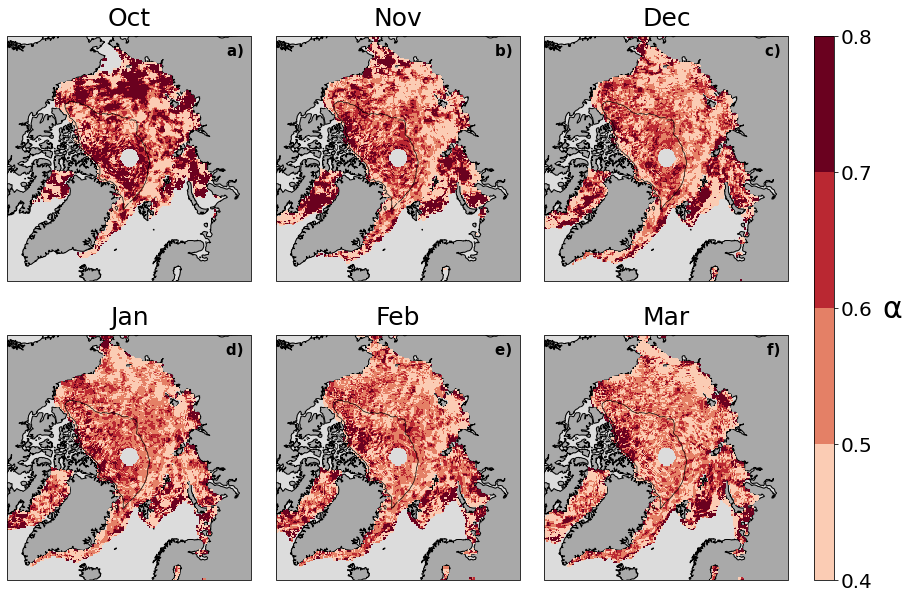

In [7]:
lats = np.load('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/auxiliary/lat_25km.npy')
lons = np.load('/Users/carmennab/Dropbox/OI_PolarSnow/EASE/auxiliary/lon_25km.npy')
icetype_lon = np.array(icetype['lon'])
icetype_lat = np.array(icetype['lat'])

nums = ['a) ', 'b) ', 'c) ', 'd) ', 'e) ', 'f) ']
labels = ['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar']
list_colors = ['#FBCCB4','#E48066','#BA2832','#6A011F'] 

fig = plt.figure(figsize=(14,11))
spec = gridspec.GridSpec(ncols=3, nrows=2,hspace=0.,wspace=0.1)

for counter in np.arange(0,6):
    ax = fig.add_subplot(spec[counter],projection=ccrs.NorthPolarStereo())
    alpha = seasonal_alphas[months[counter]]
    ax.text(0.99, 0.92, nums[counter],ha='right',fontsize=15,fontweight='bold',transform=ax.transAxes)
    ax.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=1)
    ax.add_feature(cartopy.feature.OCEAN, color='gainsboro', edgecolor='black')
    ax.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
    ax.coastlines()
    
    cm = LinearSegmentedColormap.from_list('map', list_colors, N = 4)
    p_map = ax.pcolormesh(lons,lats,alpha,cmap=cm,vmin=0.4,vmax=0.8,transform=ccrs.PlateCarree())
    ax.set_title(labels[counter],fontsize=25, pad=10)

    cont_less = ax.contour(lon2d_lesser,
                  lat2d_lesser,
                  ice_type_lesser,
                  levels=[0.5],
                  transform=ccrs.PlateCarree(),
                  colors='k',
                  linewidths=0.7)

    cont_Great = ax.contour(lon2d_greater,
                  lat2d_greater,
                  ice_type_greater,
                  levels=[0.5],
                  transform=ccrs.PlateCarree(),
                  colors='k',
                  linewidths=0.7)
    
    if counter == 5: 
        cbar_ax = fig.add_axes([0.925, 0.1585, 0.02, 0.687]) # x, y, width, height
        a = fig.colorbar(p_map, cax=cbar_ax)
        a.ax.tick_params(labelsize=20)
        a.set_ticks([0.4,0.5,0.6,0.7,0.8])
        a.set_label("\u03B1", fontsize = 30 ,labelpad = 20, rotation=0,y=0.525)

plt.savefig('/Users/carmennab/Dropbox/Apps/Overleaf/Snow Interpolated Freeboards/main_figs/alpha.png',bbox_inches = "tight")